In [62]:
!nvidia-smi

Mon Nov  2 15:14:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8     6W /  N/A |   7600MiB /  7982MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
%matplotlib inline
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as cPickle, random, sys, keras
import scipy
from sklearn import preprocessing
import tensorflow as tf
from numpy.fft import *


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

Xd = cPickle.load(open("RML2016.10b.dat",'rb'), encoding='latin1')

# Dataset of only HIGH SNRs [SNR-18]

In [2]:
INTENSITY_AXIS=0
QUADRATURE_AXIS=1

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])


In [3]:
X_Intensity = []  
X_Quadrature = []
Label_strings = []
for mod in mods:
    X_Intensity.append(Xd[(mod,18)][:,INTENSITY_AXIS,:])
    X_Quadrature.append(Xd[(mod,18)][:,QUADRATURE_AXIS,:])
    for label in range(len(Xd[(mod,18)][:,INTENSITY_AXIS,:])):
        Label_strings.append(mod)
X_Intensity = np.vstack(X_Intensity) # Quick way to create stacked dataset
#X_Intensity = preprocessing.StandardScaler().fit_transform(X_Intensity)


X_Quadrature = np.vstack(X_Quadrature)
#X_Quadrature = preprocessing.StandardScaler().fit_transform(X_Quadrature)

Label_strings=np.vstack(Label_strings)


complex_num = X_Intensity + 1j*X_Quadrature


In [5]:
X_Intensity.shape

(60000, 128)

In [4]:
X_Intensity_Manually = [Xd[('8PSK',18)][:,0,:],Xd[('AM-DSB',18)][:,0,:],Xd[('BPSK',18)][:,0,:],Xd[('CPFSK',18)][:,0,:]
    ,Xd[('GFSK',18)][:,0,:],Xd[('PAM4',18)][:,0,:],Xd[('QAM16',18)][:,0,:],Xd[('QAM64',18)][:,0,:]
    ,Xd[('QPSK',18)][:,0,:],Xd[('WBFM',18)][:,0,:]]
X_Intensity_Manually = np.vstack(X_Intensity_Manually) # Manually Creaete 

In [5]:
list(mods)

['8PSK',
 'AM-DSB',
 'BPSK',
 'CPFSK',
 'GFSK',
 'PAM4',
 'QAM16',
 'QAM64',
 'QPSK',
 'WBFM']

In [6]:
X_Intensity_FFT = abs(np.fft.fftshift(fft(X_Intensity[:]-np.mean(X_Intensity[:]))))
X_Qudrature_FFT = abs(np.fft.fftshift(fft(X_Quadrature[:]-np.mean(X_Quadrature[:]))))

In [7]:
le= preprocessing.LabelEncoder()
le.fit(Label_strings)
Label_Y_numbers = le.transform(Label_strings)

depth = 10

Label = tf.one_hot(Label_Y_numbers,depth)

/home/jax/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [8]:
Label_Y_numbers

array([0, 0, 0, ..., 9, 9, 9])

In [9]:
Label

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [10]:
X_Intensity_Label = np.c_[X_Intensity_FFT, Label]
X_Quadrature_Label = np.c_[X_Qudrature_FFT,Label]


In [11]:
import copy
X_Intensity_Label_shuffled = copy.copy(X_Intensity_Label) # Create another copy to shuffle
X_Quadratue_Label_shuffled = copy.copy(X_Quadrature_Label)

In [12]:
np.random.shuffle(X_Intensity_Label_shuffled)
np.random.shuffle(X_Quadratue_Label_shuffled)

In [13]:
length_of_X_train = int(0.7*X_Intensity_Label_shuffled.shape[0]) #42000
length_of_X_validation = (int(0.2*X_Intensity_Label_shuffled.shape[0]))+length_of_X_train #12000
print(length_of_X_validation)

54000


In [15]:
Train_Intensity = X_Intensity_Label_shuffled[0:length_of_X_train,0:128]
Y_Intensity = X_Intensity_Label_shuffled[0:length_of_X_train,128:]

Validation_Intensity = X_Intensity_Label_shuffled[length_of_X_train:length_of_X_validation,0:128]
Y_Validation = X_Intensity_Label_shuffled[length_of_X_train:length_of_X_validation,128:]

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
model2 = Sequential()
model2.add(Dense(128, input_dim=128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [63]:
history = model2.fit(Train_Intensity, Y_Intensity, epochs=250, batch_size=100,callbacks=[callback])

Epoch 1/250
420/420 [==============================] - 1s 3ms/step - loss: 1.4859 - accuracy: 0.4018
Epoch 2/250
420/420 [==============================] - 1s 3ms/step - loss: 1.1979 - accuracy: 0.4701
Epoch 3/250
420/420 [==============================] - 1s 2ms/step - loss: 1.0946 - accuracy: 0.5015
Epoch 4/250
420/420 [==============================] - 1s 3ms/step - loss: 1.0599 - accuracy: 0.5134
Epoch 5/250
420/420 [==============================] - 1s 3ms/step - loss: 1.0426 - accuracy: 0.5157
Epoch 6/250
420/420 [==============================] - 1s 3ms/step - loss: 1.0349 - accuracy: 0.5184
Epoch 7/250
420/420 [==============================] - 1s 3ms/step - loss: 1.0281 - accuracy: 0.5200
Epoch 8/250
420/420 [==============================] - 1s 2ms/step - loss: 1.0208 - accuracy: 0.5224
Epoch 9/250
420/420 [==============================] - 1s 3ms/step - loss: 1.0153 - accuracy: 0.5277
Epoch 10/250
420/420 [==============================] - 1s 3ms/step - loss: 1.0105 - accura

420/420 [==============================] - 1s 3ms/step - loss: 0.8386 - accuracy: 0.6200
Epoch 161/250
420/420 [==============================] - 1s 2ms/step - loss: 0.8359 - accuracy: 0.6211
Epoch 162/250
420/420 [==============================] - 1s 2ms/step - loss: 0.8377 - accuracy: 0.6192
Epoch 163/250
420/420 [==============================] - 1s 2ms/step - loss: 0.8373 - accuracy: 0.6208
Epoch 164/250
420/420 [==============================] - 1s 2ms/step - loss: 0.8366 - accuracy: 0.6219
Epoch 165/250
420/420 [==============================] - 1s 2ms/step - loss: 0.8356 - accuracy: 0.6217
Epoch 166/250
420/420 [==============================] - 2s 4ms/step - loss: 0.8334 - accuracy: 0.6218
Epoch 167/250
420/420 [==============================] - 1s 4ms/step - loss: 0.8330 - accuracy: 0.6240
Epoch 168/250
420/420 [==============================] - 1s 3ms/step - loss: 0.8319 - accuracy: 0.6239
Epoch 169/250
420/420 [==============================] - 1s 3ms/step - loss: 0.8344 - a

In [64]:
_, accuracy = model2.evaluate(Validation_Intensity, Y_Validation)
print('Accuracy: %.2f' % (accuracy*100))

375/375 [==============================] - 0s 796us/step - loss: 1.0563 - accuracy: 0.5805
Accuracy: 58.05


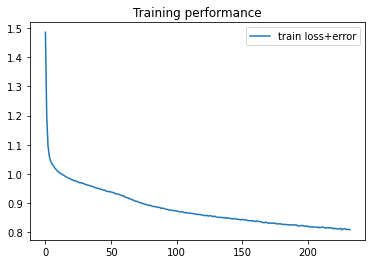

In [65]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()


In [66]:
Train_Quadrature = X_Quadratue_Label_shuffled[0:length_of_X_train,0:128]
Y_Quadrature = X_Quadratue_Label_shuffled[0:length_of_X_train,128:]

Validation_Quadraturey = X_Quadratue_Label_shuffled[length_of_X_train:length_of_X_validation,0:128]
Y_Validation_Quadrature = X_Quadratue_Label_shuffled[length_of_X_train:length_of_X_validation,128:]

In [166]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)

model_Quadrature = Sequential()
model_Quadrature.add(Dense(128, input_dim=128, activation='relu'))
model_Quadrature.add(Dense(64, activation='relu'))
model_Quadrature.add(Dense(32, activation='relu'))
model_Quadrature.add(Dense(10, activation='softmax'))

model_Quadrature.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [167]:
history_Quadrature = model_Quadrature.fit(Train_Quadrature, Y_Quadrature, epochs=4000,validation_data=(Validation_Quadraturey, Y_Validation_Quadrature), batch_size=100,
                     callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

Epoch 1/4000
420/420 [==============================] - 1s 2ms/step - loss: 1.5394 - accuracy: 0.3775 - val_loss: 1.3387 - val_accuracy: 0.4501
Epoch 2/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.2040 - accuracy: 0.4833 - val_loss: 1.1089 - val_accuracy: 0.5080
Epoch 3/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.0884 - accuracy: 0.5088 - val_loss: 1.0574 - val_accuracy: 0.5133
Epoch 4/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.0569 - accuracy: 0.5205 - val_loss: 1.0321 - val_accuracy: 0.5338
Epoch 5/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.0396 - accuracy: 0.5247 - val_loss: 1.0192 - val_accuracy: 0.5312
Epoch 6/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.0276 - accuracy: 0.5312 - val_loss: 1.0389 - val_accuracy: 0.5276
Epoch 7/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.0170 - accuracy: 0.5337 - val_loss: 1.0096 - val_accuracy:

In [168]:
_, accuracy = model_Quadrature.evaluate(Validation_Quadraturey, Y_Validation_Quadrature)
print('Accuracy: %.2f' % (accuracy*100))


375/375 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5755
Accuracy: 57.55


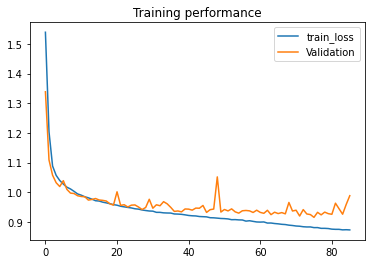

In [169]:
plt.figure()
plt.title('Training performance')
#plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')
#plt.plot(history3.epoch, history3.history['val_loss'], label= 'val_loss')
plt.plot(history_Quadrature.history['loss'], label='train_loss')
plt.plot(history_Quadrature.history['val_loss'], label='Validation')
plt.legend()
plt.show()


In [14]:
X_complex_FFT = abs(np.fft.fftshift(fft(complex_num[:]-np.mean(complex_num[:]))))

X_complex_Label = np.c_[X_complex_FFT,Label]

import copy
X_complex_Label_shuffled = copy.copy(X_complex_Label) # Create another copy to shuffle


In [15]:
np.random.shuffle(X_complex_Label_shuffled)

In [16]:
Train_complex = X_complex_Label_shuffled[0:length_of_X_train,0:128]
Y_complex = X_complex_Label_shuffled[0:length_of_X_train,128:]

print(Train_complex.shape)
Validation_complex = X_complex_Label_shuffled[length_of_X_train:length_of_X_validation,0:128]
Y_validation_complex = X_complex_Label_shuffled[length_of_X_train:length_of_X_validation,128:]

(42000, 128)


In [18]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model3 = Sequential()
model3.add(Dense(128, input_dim=128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history3 = model3.fit(Train_complex, Y_complex, epochs=6000, batch_size=100,validation_data=(Validation_complex, Y_validation_complex),
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

In [152]:
_, accuracy = model3.evaluate(Validation_complex, Y_validation_complex)
print('Accuracy: %.2f' % (accuracy*100))

375/375 [==============================] - 0s 1ms/step - loss: 0.6575 - accuracy: 0.6757
Accuracy: 67.57


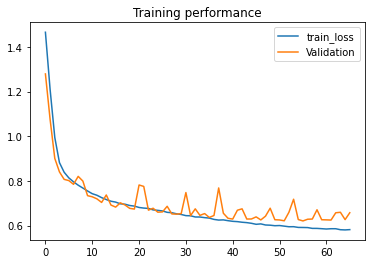

In [153]:
plt.figure()
plt.title('Training performance')
#plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')
#plt.plot(history3.epoch, history3.history['val_loss'], label= 'val_loss')
plt.plot(history3.history['loss'], label='train_loss')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend()
plt.show()


In [19]:
from sklearn.model_selection import GridSearchCV
parameters ={'batch_size':[50,100,150],
            'nb_epoch':[100,200,300],
            'optimizer':['adam','rmsprop','SGD'],
            'kernel_initializer':['random_uniform'],
            'units':[4,8,13]}
gridSearch = GridSearchCV(estimator=model3,
                          param_grid=parameters,
                          cv=10,
                         n_jobs=-1,
                         return_train_score=True)

In [21]:
gridSearch.fit(Train_Intensity, Y_Intensity)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f5e00f6d550> does not.

In [22]:
#n_timesteps, n_features, n_outputs = Train_complex.shape[1], Train_complex.shape[2], Y_complex.shape[1]

IndexError: tuple index out of range